In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Installing the required packages
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model


The mask detecction problem can be solved in two different ways
1.Detecting the faces in a image using opencv and training a model to detect faces with masks using transfer learning.
2.Custom Object Detection using YOLOV3
Here we will be using both the ways to get the best result.
The data.csv is the custom built dataset of faces wearing masks and not wearing masks.

In [ ]:
data=pd.read_csv('/content/drive/My Drive/data.csv')

In [ ]:
data.to_csv('data.csv')

In [ ]:
data.head()

,path,label
0,without_mask/151.jpg,0
1,without_mask/15.jpg,0
2,without_mask/149.jpg,0
3,without_mask/140.jpg,0
4,without_mask/146.jpg,0


In [ ]:
#Shuffling the dataset
from sklearn.utils import shuffle
data = shuffle(data)

In [ ]:
data.label.value_counts()

1    694
0    686
Name: label, dtype: int64

In [ ]:
data['path']=data['path'].astype(str)
data['label']=data['label'].astype(str)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#Test train Split
train, test = train_test_split(data, test_size=0.2)

In [ ]:
train.shape

(1100, 2)

In [ ]:

datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=data,
directory="/content/drive/My Drive/dataset/",
x_col="path",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 1380 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory="/content/drive/My Drive/dataset/",
x_col="path",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 220 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/drive/My Drive/dataset/",
x_col="path",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))

Found 276 validated image filenames.


In [ ]:
#Transfer Learning using VGG-16
from tensorflow.keras import applications

# This will load the whole VGG16 network, including the top Dense layers.
# Note: by specifying the shape of top layers, input tensor shape is forced
# to be (224, 224, 3), therefore you can use it only on 224x224 images.
vgg_model = applications.VGG16(weights='imagenet', include_top=True)

# If you are only interested in convolution filters. Note that by not
# specifying the shape of top layers, the input tensor shape is (None, None, 3),
# so you can use them for any size of images.
vgg_model = applications.VGG16(weights='imagenet', include_top=False)

# If you want to specify input tensor
from tensorflow.keras.layers import Input
input_tensor = Input(shape=(224, 224, 3),name='input_tensor')

vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)
output_vgg16 = vgg_model(input_tensor)
vgg_model.trainable=False

# To see the models' architecture and layer names, run the following
vgg_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
Conv1 (Conv2D)               (None, 5, 5, 512)         2359808   
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 2, 2, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 2048)              4196352   
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              209817

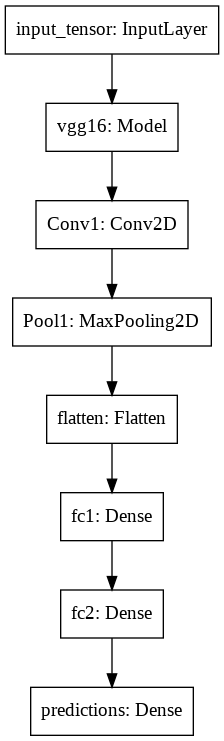

In [ ]:
#Add the fully-connected layers
Conv1 = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1')(output_vgg16) 
Pool1 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')(Conv1)
x = Flatten(name='flatten')(Pool1)
x = Dense(2048, activation='sigmoid', name='fc1')(x)
x = Dense(1024, activation='sigmoid', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)
from tensorflow.keras.models import Model
#Create your own model 
my_model = Model(inputs=input_tensor,outputs=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()
plot_model(my_model, to_file='shared_input_layer.png')

In [ ]:
my_model.compile(tf.keras.optimizers.Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
my_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    #validation_data=valid_generator,
                    #validation_steps=STEP_SIZE_VALID,
                    epochs=5
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
43/43 [==============================] - 676s 16s/step - loss: 0.7362 - accuracy: 0.7945
Epoch 2/5
43/43 [==============================] - 668s 16s/step - loss: 0.0494 - accuracy: 0.9844
Epoch 3/5
43/43 [==============================] - 665s 15s/step - loss: 0.0055 - accuracy: 0.9985
Epoch 4/5
43/43 [==============================] - 666s 15s/step - loss: 0.0018 - accuracy: 1.0000
Epoch 5/5
43/43 [==============================] - 670s 16s/step - loss: 4.8033e-04 - accuracy: 1.0000


In [ ]:
my_model.save("model", save_format="h5")

In [ ]:
model = load_model("/content/drive/My Drive/model")

This model gives a 100 percent accuracy for mask detection but this dataset is very good at detecting single faces  in a image.The opencv is not able to detect multiple faces in a image.The problem with the dataset is that it is trained on only white layered masks.Getting dataset which can have multiple coloured masks was difficult.Opencv was also not able to detect multiple faces in a single image properly.

In [ ]:
import cv2

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np


Object Detection.

In [ ]:
!pip3 install tensorflow-gpu==1.13.1

In [ ]:
!pip3 install imageai --upgrade

In [ ]:
!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/essential-v4/pretrained-yolov3.h5

In [ ]:
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="/content/drive/My Drive/yolo_data")
trainer.setTrainConfig(object_names_array=["without_mask","with_mask","mask_weared_incorrect"], batch_size=4, num_experiments=3, train_from_pretrained_model="pretrained-yolov3.h5")
trainer.trainModel()

In [ ]:
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="/content/drive/My Drive/mask_data")
metrics = trainer.evaluateModel(model_path="/content/drive/My Drive/mask_data/models/", json_path="/content/drive/My Drive/mask_data/json/detection_config.json", iou_threshold=0.5, object_threshold=0.3, nms_threshold=0.5)
print(metrics)

In [ ]:

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("/content/drive/My Drive/mask_data/models/2.h5")
detector.setJsonPath("/content/drive/My Drive/mask_data/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image="/content/drive/My Drive/1.jpg", output_image_path="holo1-detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

with_mask  :  74.47237968444824  :  [19, 87, 52, 104]
without_mask  :  56.302136182785034  :  [19, 87, 52, 104]
with_mask  :  61.60667538642883  :  [250, 105, 259, 127]
without_mask  :  57.023411989212036  :  [250, 105, 259, 127]
with_mask  :  60.23245453834534  :  [300, 114, 311, 140]
without_mask  :  54.22881841659546  :  [298, 124, 312, 146]
with_mask  :  68.3768630027771  :  [215, 137, 225, 158]
without_mask  :  50.78434944152832  :  [215, 137, 225, 158]
with_mask  :  61.840105056762695  :  [795, 137, 808, 155]
with_mask  :  75.6121039390564  :  [445, 150, 457, 168]
without_mask  :  63.4094774723053  :  [445, 150, 457, 168]
with_mask  :  64.20811414718628  :  [693, 144, 705, 171]
without_mask  :  52.815043926239014  :  [693, 144, 705, 171]
with_mask  :  71.66393995285034  :  [391, 158, 418, 181]
without_mask  :  59.41612124443054  :  [391, 158, 418, 181]
with_mask  :  58.33413600921631  :  [385, 145, 424, 195]
with_mask  :  63.004857301712036  :  [409, 157, 425, 181]
without_mask  

In [ ]:
from imageai.Detection.Custom import CustomVideoObjectDetection
import os

video_detector = CustomVideoObjectDetection()
video_detector.setModelTypeAsYOLOv3()
video_detector.setModelPath("/content/drive/My Drive/mask_data/models/2.h5")
video_detector.setJsonPath("/content/drive/My Drive/mask_data/json/detection_config.json")
video_detector.loadModel()

video_detector.detectObjectsFromVideo(input_file_path="holo1.mp4",
                                        output_file_path=("holo1-detected"),
                                        frames_per_second=30,
                                        minimum_percentage_probability=40,
                                        log_progress=True)

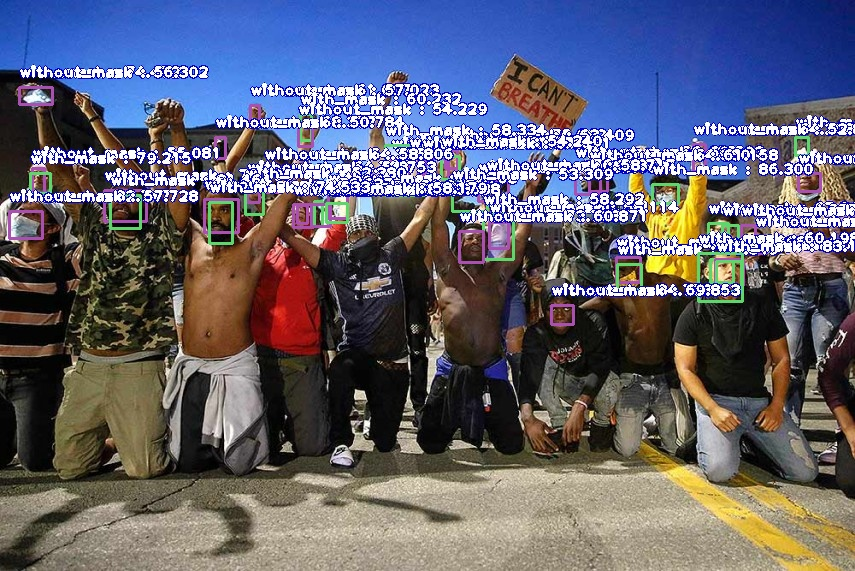

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(r"C:\Users\sheky\Downloads\holo1-detected1.jpg")

Here the maximum time alloted for a VM was 12 hrs only.So I could only run 2 epochs.If this had been run for another 2-3 epochs,then the result would have been very promising.It took me 4 and half hrs for a single epoch.Object detction method is much more promising than the transfer learning method.